### **Method 1**

1. upload all the files to the google colab storage session
2. using the sqldf library to run sql queries

In [ ]:
!pip install sqldf

In [ ]:
#import libraries
import sqldf
import pandas as pd

#use pandas to import the file
#the path is from the google colab storage session
circuits = pd.read_csv('/content/circuits.csv')
circuits.head(2)


#run the query
query = """
SELECT *
FROM circuits
LIMIT 5

"""

sqldf.run(query)

,index,circuitId,circuitRef,name,location,country,lat,lng,alt,url
0,0,1,albert_park,Albert Park Grand Prix Circuit,Melbourne,Australia,-37.84970,144.96800,10,http://en.wikipedia.org/wiki/Melbourne_Grand_P...
1,1,2,sepang,Sepang International Circuit,Kuala Lumpur,Malaysia,2.76083,101.73800,18,http://en.wikipedia.org/wiki/Sepang_Internatio...
2,2,3,bahrain,Bahrain International Circuit,Sakhir,Bahrain,26.03250,50.51060,7,http://en.wikipedia.org/wiki/Bahrain_Internati...
3,3,4,catalunya,Circuit de Barcelona-Catalunya,Montmeló,Spain,41.57000,2.26111,109,http://en.wikipedia.org/wiki/Circuit_de_Barcel...
4,4,5,istanbul,Istanbul Park,Istanbul,Turkey,40.95170,29.40500,130,http://en.wikipedia.org/wiki/Istanbul_Park


In [ ]:
#demonstrating joins with sqldf
#for some reason, aliases don't seem to work

constructors = pd.read_csv('/content/constructors.csv')
constructors_standings = pd.read_csv('/content/constructor_standings.csv')

query = """
SELECT constructors.name,
       SUM(constructors_standings.points) AS total_points
FROM constructors
LEFT JOIN constructors_standings   ON
  constructors.constructorId = constructors_standings.constructorId
GROUP BY constructors.name
ORDER BY total_points DESC
LIMIT 10
"""

sqldf.run(query)

,name,total_points
0,Ferrari,96699.0
1,Red Bull,77850.5
2,Mercedes,77810.5
3,McLaren,61413.5
4,Williams,32398.5
5,Renault,17168.0
6,Force India,10347.0
7,Team Lotus,7742.0
8,Lotus F1,7485.0
9,Benetton,7349.5


### **Method 2**

#### Using sqlite3 + pandas interface

sqlite3 + pandas can only be used when you connect to a database i.e. *.db.
Cannot be used when connecting to  csv file.
Otherwise, you have to convert all the csv files into a db and then use.

In [ ]:
# #import library
# import sqlite3

# #create connection
# conn = sqlite3.connect('example_database.db')

# #query
# query = """
# SELECT *
# FROM database
# LIMIT 5
# """

# # pd.read_sql(query, conn)

### import libraries

In [2]:
#for sql
!pip install sqldf
import sqldf
import pandas as pd
#for viz
import seaborn as sns
import matplotlib.pyplot as plt

# ***A History of F1: The Fastest Sport in the world***

Since its inception in 1950, Formula 1, often referred to as F1, has been celebrated as the pinnacle of motor racing. Emerging from a mix of amateur racing enthusiasts with a penchant for daredevilry and automotive manufacturers eager to showcase their cars, the sport has evolved and become renowned for being at the forefront of innovation and technology. It inspires millions of race fans worldwide as teams and drivers compete against each other and the clock, striving for the ultimate honor of being crowned world champions.

As a fan of F-1 since the late 90's, I'm going to dig into the data and see what insights I can gather and get a look at how the sport I love so dearly has evolved and also paint a picture for anyone curious to see what F1 is all about.

The dataset used spans the years 1950-1975 and can be found here:
[dataset](https://https://www.kaggle.com/datasets/rohanrao/formula-1-world-championship-1950-2020?resource=download#)

## ***The Basics***

Let's start with the basics:

F-1 is comprised of teams who build the cars and employ drivers who race them. Although a team sport, it's usually the drivers who get all the attention. They are the most visible part of the team and in teams that are fielded by manufacturers, they also become the de-fato face of the brand. They also risk their lives since motor-racing is inherently a dangerous sport.

So, let's see what we can find out about the various teams and drivers who have a part of F1 in the past 75 years.

### ***Teams***

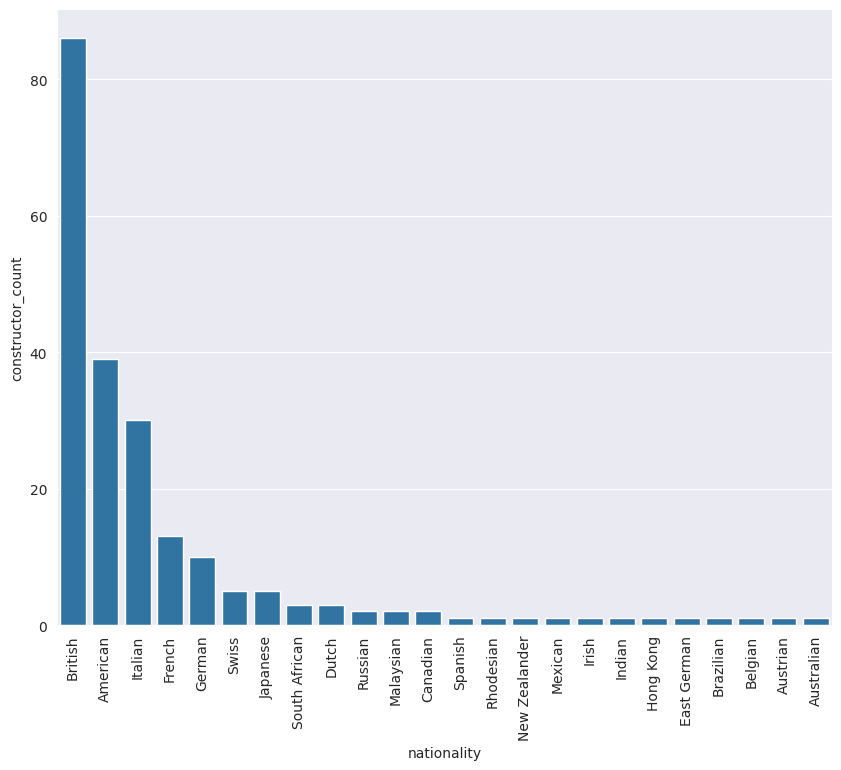

In [35]:
#grouping constructors and nationality
#read the csv file
constructors = pd.read_csv('/content/constructors.csv')

query = """
SELECT nationality,
       COUNT(*) AS constructor_count
FROM constructors
GROUP BY nationality
ORDER BY constructor_count DESC
"""
#convert to df to plot
result = sqldf.run(query)

#plot

#set figure size
plt.figure(figsize = (10,8))
#set background color for the bar chart
sns.set_style('darkgrid')
#plot bar chart
sns.barplot(data=result, x='nationality', y='constructor_count');
#rotate the labels for visibility
plt.xticks(rotation=90);

F1 is predominantly based in Europe with the UK dubbed as the Silicon Valley of the sport. Even most current teams have their racing HQ's and facilities in the UK. Hence, it is not unsurprising to see that most F1 teams are European and a majority overwhelmingly English.

Let's look at the composition of teams across the sports history:

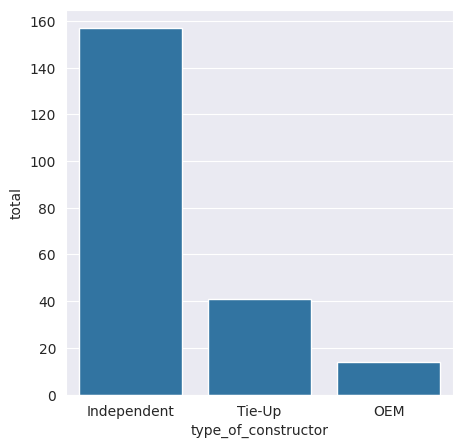

In [36]:
query="""
SELECT type AS type_of_constructor,
       count(*) AS total
FROM constructors
GROUP BY type
ORDER BY total DESC
"""
result = sqldf.run(query)

#plot
#set figure size
plt.figure(figsize = (5,5))
#set background color for the bar chart
sns.set_style('darkgrid')
#plot bar chart
sns.barplot(data=result, x='type_of_constructor', y='total');
#rotate the labels for visibility
# plt.xticks(rotation=90);

F1 being very complex and expensive meant most teams did not last very long as they run out of money. To survive, small independent teams often tied-up with OEM's by way of sponsorship or exhange of technology. For example: an independent team could tie-up with an OEM for an engine supply deal in from them while they concentrated on other areas like the chassis, brakes etc. This also offered an OEM a cheaper way to enter the sport and also give them time to  decide if they wanted to get more involved in the future.



### ***Most successful team of all time?***

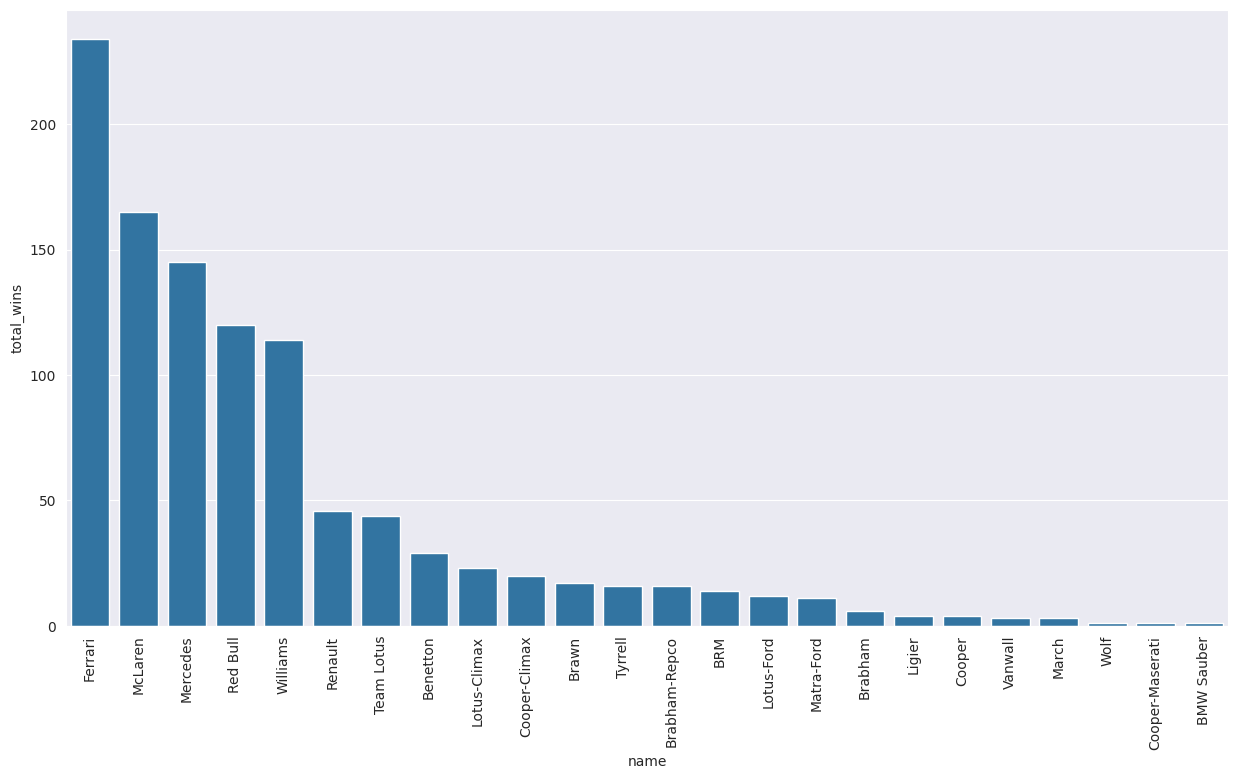

In [38]:
#find out the most successful team in the sport by wins
#read the csv file
constructor_standings = pd.read_csv('/content/constructor_standings.csv')

query = """

SELECT constructors.name,
       COUNT(*) AS total_wins
FROM constructors
JOIN constructor_standings
  ON constructors.constructorId = constructor_standings.constructorId
WHERE constructor_standings.position = 1
GROUP BY constructors.name
ORDER BY total_wins DESC

"""

result = sqldf.run(query)

#plot
#set figure size
plt.figure(figsize = (15,8))
#set background color for the bar chart
sns.set_style('darkgrid')
#plot bar chart
sns.barplot(data=result, x='name', y='total_wins');
#rotate the labels for visibility
plt.xticks(rotation=90);

In [43]:
##Only for wins
query = """

SELECT constructors.constructorId,
       constructors.name,
       COUNT(*) AS total_wins
FROM constructors
JOIN constructor_standings
  ON constructors.constructorId = constructor_standings.constructorId
WHERE constructor_standings.position = 1
GROUP BY constructors.constructorId, constructors.name
ORDER BY total_wins DESC

"""
sqldf.run(query)

,constructorId,name,total_wins
0,6,Ferrari,234
1,1,McLaren,165
2,131,Mercedes,145
3,9,Red Bull,120
4,3,Williams,114
5,4,Renault,46
6,32,Team Lotus,44
7,22,Benetton,29
8,172,Lotus-Climax,23
9,170,Cooper-Climax,20


In [51]:
#for total races
query = """

SELECT constructors.constructorId,
       constructors.name,
       COUNT(*) AS total_races
FROM constructors
JOIN constructor_standings
  ON constructors.constructorId = constructor_standings.constructorId
GROUP BY constructors.name
ORDER BY total_races DESC;

"""
sqldf.run(query)

,constructorId,name,total_races
0,6,Ferrari,1046
1,1,McLaren,917
2,3,Williams,845
3,25,Tyrrell,426
4,4,Renault,406
...,...,...,...
155,72,Kojima,2
156,124,Tec-Mec,1
157,113,Kurtis Kraft,1
158,168,Cooper-OSCA,1


In [58]:
#most successful team by win %

query = """

with race_wins AS (
SELECT constructors.constructorId,
       constructors.name,
       COUNT(*) AS total_wins
FROM constructors
JOIN constructor_standings
  ON constructors.constructorId = constructor_standings.constructorId
WHERE constructor_standings.position = 1
GROUP BY constructors.constructorId, constructors.name
ORDER BY total_wins DESC
)

,

races AS (
SELECT constructors.constructorId,
       constructors.name,
       COUNT(*) AS total_races
FROM constructors
JOIN constructor_standings
  ON constructors.constructorId = constructor_standings.constructorId
GROUP BY constructors.name
ORDER BY total_races DESC;
)

SELECT race_wins.name,
       race_wins.total_wins,
       races.total_races,
       ROUND(race_wins.total_wins / races.total_races * 100, 2) AS win_percentage
FROM race_wins
JOIN races ON
    race_wins.constructorId = races.constructorId
ORDER BY win_percentage DESC;

"""
result = sqldf.run(query)
result.head()



AttributeError: module '__main__' has no attribute 'race_wins'